## Functions

In [1]:
def split_data(X, y):
    """Function to split data into Training and Testing feature"""
    X1 = X.drop(['ID'], axis=1)
    X_c = autoclean(X1)
    
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, test_size=0.3, random_state=33)
    
    return X_train, X_test, y_train, y_test

In [2]:
def base_model(X_train, X_test, y_train, y_test):
    """Function to run various models on the dataset"""
    
    models = {
        ('LR', LinearRegression()),
        ('LS', Lasso()),
        ('RI', Ridge()),
        ('EN', ElasticNet()),
        ('RFR', RandomForestRegressor()),
        ('GBR', GradientBoostingRegressor()),
        ('ABR', AdaBoostRegressor())
    }
    
    mods, tr_acc, te_acc, rmse_sc, mae_sc = [], [], [], [], []
    
    for name, model in models:
        clf = model
        clf.fit(X_train, y_train) # Fit Model
        y_pred = clf.predict(X_test) # Predict Target using Model
        
        mods.append(name) # Model Names
        
        tra = clf.score(X_train, y_train) # Train score
        tr_acc.append(tra)
        
        tea = clf.score(X_test, y_test) # Test score
        te_acc.append(tea)
        
        rmsc = np.sqrt(round(mean_squared_error(y_test, y_pred), 2)) # RMSE score
        rmse_sc.append(rmsc)
        
        msc = round(mean_absolute_error(y_test, y_pred), 2) # MAE score
        mae_sc.append(msc)
    
    x = {
        'Model': mods,
        'Train Accuracy': tr_acc, 
        'Test Accuracy': te_acc, 
        'MAE score': mae_sc, 
        'RMSE score': rmse_sc
    }
    
    return pd.DataFrame(x)

In [3]:
def fs_plot(X, y, model):
    """Function to plot the feature significance"""
    cols = X.columns.tolist()

    X_c = autoclean(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

    model.fit(X_train, y_train)

    # perform xgb importance
    xgb_fea_imp = pd.DataFrame(list(model.get_booster().get_fscore().items()), 
                            columns=['feature','importance']).sort_values('importance', ascending=False)

    # get xgb importance
    xgb_sig = model.feature_importances_

    # perform permutation importance
    results = permutation_importance(model, X, y, scoring='neg_root_mean_squared_error')

    # get permutation importance
    importance = results.importances_mean

    # List of feature f score
    print('Feature Importance using f score :\n', '', xgb_fea_imp)
    print('-'*50)

    # Plot feature f score
    plot_importance(model, )
    plt.show()
    print('-'*50)

    # Summarize feature importance
    print('Feature importance using xgboost :')
    for i,v in enumerate(xgb_sig):
        print('Feature: %0d, Score: %.5f' % (i,v))
    print('-'*50)

    # plot xgb feature importance
    plt.figure(figsize=[15, 4])
    plt.bar([x for x in cols], xgb_sig)
    plt.xticks(rotation=90)
    plt.show()
    print('-'*50)

    # Summarize feature importance
    print('Feature importance using permutation :')
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    print('-'*50)

    # plot permutation feature importance
    plt.figure(figsize=[15, 4])
    plt.bar([x for x in cols], importance)
    plt.xticks(rotation=90)
    plt.show()

In [4]:
def high_corel(data, co_value):
    """Function to find all the features that are highly correlated"""
    mat = data.corr().abs()
    
    upper = mat.where(np.triu(np.ones(mat.shape), k=1).astype(np.bool))
    
    to_drop = [col for col in upper.columns if any(upper[col] > co_value)]
    
    return to_drop

In [5]:
def check_corr(data):
    """FUnction to check the correlation of the dataset"""
    
    X_c = autoclean(X)
    
    plt.figure(figsize=[12,10])
    g = sns.heatmap(X_c.corr())
    plt.show()
    print('-'*50)

In [6]:
def to_minutes(x):
    """Function to convert time data into minute values"""
    a = pd.to_numeric(x.strftime('%H')) * 60
    b = pd.to_numeric(x.strftime('%M'))
    
    return a + b

def days_to(x):
    """Function to convert days into minutes"""
    return pd.to_numeric(x) * 24 *  60

# Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datacleaner import autoclean
import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

from scipy import stats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.svm import SVR, LinearSVR

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.feature_selection import chi2, f_classif, f_regression, SelectKBest
from sklearn.inspection import permutation_importance

# A. Train Set

### 1. Load Data

In [8]:
# Train Set
total_df = pd.read_csv(r"/home/praveen/Downloads/Data Science/Data projects/flight_time/file/Train.csv")

# Test Set
test_df = pd.read_csv(r"/home/praveen/Downloads/Data Science/Data projects/flight_time/file/Test.csv")

### 2. EDA

In [9]:
# Creating unique feature for identification between Validation and Train Feature
total_df['train'] = 1
test_df['train'] = 0

# Sorting target variable from train and validation data into 2 different variables
y = total_df['target'].copy()
test_id = test_df['ID'].copy()

# Concating train and validation data
total_df = total_df.drop('target', axis=1) # Concated features
df = pd.concat([total_df, test_df])

In [10]:
df.shape

(117166, 10)

In [11]:
df.sample(5).T

,7562,8586,90430,62328,94191
ID,test_id_7562,test_id_8586,train_id_90430,train_id_62328,train_id_94191
DATOP,2018-09-17,2018-09-29,2018-04-24,2017-07-03,2018-05-24
FLTID,TU 0996,TU 0647,TU 0716,TU 2007,TU 0208
DEPSTN,TUN,FRA,TUN,MXP,TUN
ARRSTN,NCE,MIR,ORY,MIR,NTE
STD,2018-09-17 07:50:00,2018-09-29 17:40:00,2018-04-24 06:10:00,2017-07-03 21:20:00,2018-05-24 13:20:00
STA,2018-09-17 09.20.00,2018-09-29 20.10.00,2018-04-24 08.30.00,2017-07-03 23.20.00,2018-05-24 15.45.00
STATUS,ATA,ATA,ATA,ATA,ATA
AC,TU 320IMT,TU 32AIML,TU 320IMV,TU 736IOL,TU 32AIMD
train,0,0,1,1,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117166 entries, 0 to 9332
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ID      117166 non-null  object
 1   DATOP   117166 non-null  object
 2   FLTID   117166 non-null  object
 3   DEPSTN  117166 non-null  object
 4   ARRSTN  117166 non-null  object
 5   STD     117166 non-null  object
 6   STA     117166 non-null  object
 7   STATUS  117166 non-null  object
 8   AC      117166 non-null  object
 9   train   117166 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 9.8+ MB


#### 2a. Unique values in each feature

In [13]:
df.nunique()*100/df.shape[0]

ID        100.000000
DATOP       0.935425
FLTID       1.631873
DEPSTN      0.114368
ARRSTN      0.110954
STD        75.712237
STA        78.882099
STATUS      0.004267
AC          0.059744
train       0.001707
dtype: float64

### 3. Base Model
    Running Data on the following algorithms -
    a. Linear Regression (LR)
    b. Ridge Regression (RI)
    c. Random Forest Regressor (RFR)
    d. Adaptive Boost Regressor (ABR)
    e. Gradient Boost Regressor (GBR)
    f. Elastic Net (EN)
    g. Lasso Regression (LS)

In [14]:
X_train, X_test, y_train, y_test = split_data(total_df, y)

In [15]:
base_model(X_train, X_test, y_train, y_test)

,Model,Train Accuracy,Test Accuracy,MAE score,RMSE score
0,RI,0.031919,0.034070,55.66,113.594674
1,RFR,0.891581,0.251718,44.03,99.981098
2,LR,0.031919,0.034070,55.66,113.594674
3,EN,0.030722,0.032782,55.53,113.670401
4,GBR,0.114076,0.090728,51.49,110.212840
5,LS,0.031774,0.033950,55.58,113.601761
6,ABR,-0.114825,-0.115574,77.86,122.077148


### 4. Regression Analysis

In [16]:
X = total_df.drop(['ID'], axis=1)  # Features

cols = X.columns.tolist()

X_c = autoclean(X) # Clean and Label data

X_base = sm.add_constant(X_c)
model = sm.OLS(y, X_base)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     453.6
Date:                Wed, 22 Dec 2021   Prob (F-statistic):               0.00
Time:                        13:48:18   Log-Likelihood:            -6.6487e+05
No. Observations:              107833   AIC:                         1.330e+06
Df Residuals:                  107824   BIC:                         1.330e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
DATOP          0.2401      0.044      5.400      0.0

### 5. Feature Selection Plot

Feature Importance using f score :
    feature  importance
4      ID        1315
3   FLTID         864
1     STD         647
6      AC         556
7   DATOP         464
2     STA         372
8  DEPSTN         356
5  ARRSTN         228
0  STATUS          49
--------------------------------------------------


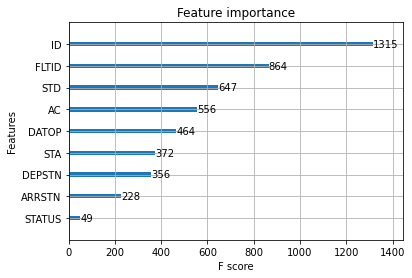

--------------------------------------------------
Feature importance using xgboost :
Feature: 0, Score: 0.07171
Feature: 1, Score: 0.06317
Feature: 2, Score: 0.07240
Feature: 3, Score: 0.05249
Feature: 4, Score: 0.05150
Feature: 5, Score: 0.11430
Feature: 6, Score: 0.13293
Feature: 7, Score: 0.38589
Feature: 8, Score: 0.05559
Feature: 9, Score: 0.00000
--------------------------------------------------


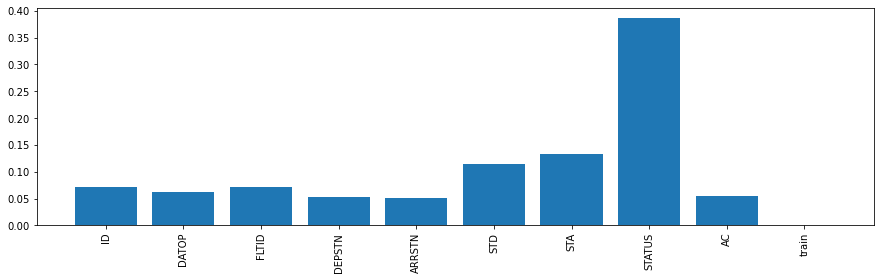

--------------------------------------------------
Feature importance using permutation :
Feature: 0, Score: 9.87882
Feature: 1, Score: 33.27741
Feature: 2, Score: 20.98145
Feature: 3, Score: 14.68386
Feature: 4, Score: 4.75006
Feature: 5, Score: 352.97758
Feature: 6, Score: 348.45714
Feature: 7, Score: 3.10989
Feature: 8, Score: 9.22557
Feature: 9, Score: 0.00000
--------------------------------------------------


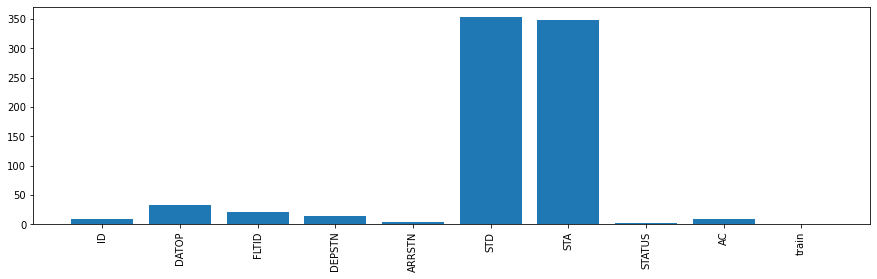

In [17]:
fs_plot(total_df, y, XGBRegressor())

### 6. Correlation Analysis

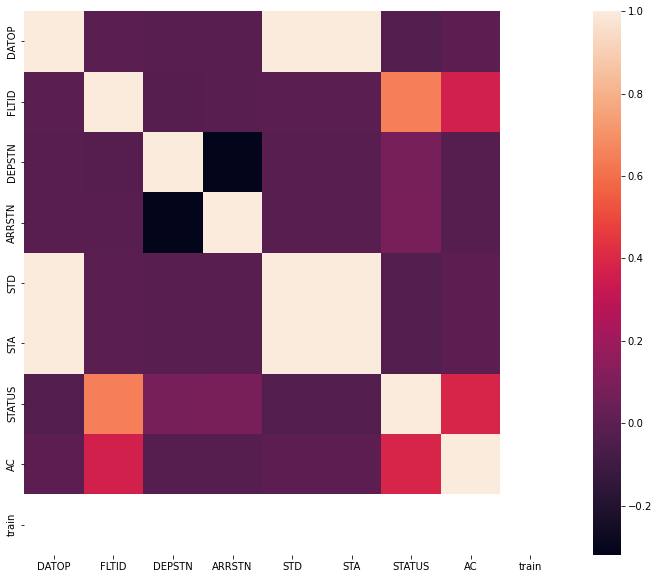

--------------------------------------------------


In [18]:
check_corr(total_df)

In [19]:
high_corel(total_df, 0.55)

['STD', 'STA', 'STATUS']

### 7. Feature Engineering
#### 7a. Flight Duration -
    Converting STA and STD to datetime format so as to calculate the flight duration

In [20]:
# STA
df['STA'] = [datetime.strptime(x, '%Y-%m-%d %H.%M.%S') for x in df['STA']]
df['STA'] = [datetime.strftime(x, '%Y-%m-%d %H:%M:%S') for x in df['STA']] # Convert STA to the same format as STD
df['STA'] = pd.to_datetime(df['STA'])

# STD
df['STD'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['STD']]
df['STD'] = pd.to_datetime(df['STD'])

# Difference from STD and STA
df['diff'] = df['STA'] - df['STD']

In [21]:
# Convert feature data type into Timedelta
df['flight_time'] = pd.to_timedelta(df['diff'])

# Convert flight duration to Total Minutes
df['flight_time'] = df['flight_time'].dt.total_seconds()/60

In [22]:
df.drop(columns=['STA', 'STD', 'diff'], axis=1, inplace=True)

### 8. Feature Scaling

In [23]:
m_scaler = MinMaxScaler() # Min Max Scaler

r_scaler = RobustScaler() # Robust Scaler

s_scaler = StandardScaler() # Standard Scaler

#### 8a. Data Distribution

In [24]:
df.skew()

train          -3.104955
flight_time    87.412500
dtype: float64

<AxesSubplot:xlabel='flight_time', ylabel='Density'>

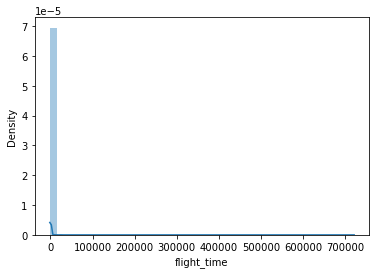

In [25]:
sns.distplot(df['flight_time'])

#### 8b. Scale Flight Time feature

In [26]:
df['flight_time'] = m_scaler.fit_transform(df[['flight_time']])

<AxesSubplot:xlabel='flight_time', ylabel='Density'>

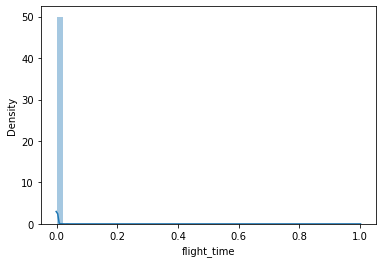

In [27]:
sns.distplot(df['flight_time'])

In [28]:
# Drop unwanted columns
df.drop(['ID', 'FLTID', 'DATOP'], axis=1, inplace=True)

In [29]:
df.columns

Index(['DEPSTN', 'ARRSTN', 'STATUS', 'AC', 'train', 'flight_time'], dtype='object')

#### 8c. Respliting (Train and Test)
    For Leave one out encoding we will need to split data into train and test set

In [30]:
tr_df = df[df['train'] == 1] # Train Data
te_df = df[df['train'] == 0] # Validation Data

#### 8d. Encoding (Binary Encoder)

In [31]:
# Encoder Variable
encoder = ce.leave_one_out.LeaveOneOutEncoder(cols=['DEPSTN', 'ARRSTN', 'AC', 'STATUS'], return_df=True)

X1_en = encoder.fit_transform(tr_df, y) # Train Data Features
te_dfx = encoder.transform(te_df) # Test data Features

In [32]:
# Train set
X1_en.drop(['train'], axis=1, inplace=True)

# Test set
te_dfx.drop(['train'], axis=1, inplace=True)

#### 8e. Train Test Split data

In [33]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1_en, y, test_size=0.3, random_state=7)

### 9. Model Evaluations

#### 9a. Ridge Regression

In [34]:
rid = Ridge()

rid.fit(X_train1, y_train1)

y_rid = rid.predict(X_test1)

print(np.sqrt(mean_squared_error(y_test1, y_rid)))

112.6249111525227


#### 9b. Lasso Regression

In [35]:
ls = Lasso()

ls.fit(X_train1, y_train1)

y_ls = ls.predict(X_test1)

print(np.sqrt(mean_squared_error(y_test1, y_ls)))

112.62503798895592


#### 9c. XGBoost Regressor

In [36]:
xgbr = XGBRegressor()

xgbr.fit(X_train1, y_train1)

y_xgb = xgbr.predict(X_test1)

print(np.sqrt(mean_squared_error(y_test1, y_xgb)))

2.718900674896797


#### 9d. Multiple Algorithms

In [37]:
base_model(X_train1, X_test1, y_train1, y_test1)

,Model,Train Accuracy,Test Accuracy,MAE score,RMSE score
0,LS,0.043916,0.046662,55.37,112.625042
1,ABR,0.843483,0.831554,35.20,47.341525
2,GBR,0.999423,0.999094,0.81,3.471311
3,RI,0.043923,0.046664,55.38,112.624908
4,EN,0.043917,0.046662,55.37,112.625042
5,RFR,0.999817,0.999581,0.06,2.362202
6,LR,0.043923,0.046665,55.38,112.624864


#### 9e. OLS Regression Analysis

In [38]:
X_ols = sm.add_constant(X_train1)
model = sm.OLS(y_train1, X_ols)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     693.5
Date:                Wed, 22 Dec 2021   Prob (F-statistic):               0.00
Time:                        13:49:18   Log-Likelihood:            -4.6545e+05
No. Observations:               75483   AIC:                         9.309e+05
Df Residuals:                   75477   BIC:                         9.310e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -60.1049      2.105    -28.549      

In [39]:
y_ols = results.predict(X_ols)

print('RMSE Score :', round(np.sqrt(mean_squared_error(y_train1, y_ols)), 2))

RMSE Score : 115.27


# B. Test Set

In [40]:
def submit_output(test, model, name):
    """Function to get output as csv file"""
    id_col = test_id
    
    model.fit(X_train1, y_train1) # Fit model
    
    preds = model.predict(test) # Predict on Test data
    
    x = {
        'id': id_col,
        'target': preds
    }
    
    output = pd.DataFrame(x) # Convert to dataframe
    
    output.reset_index(drop=True) # Drop Index
    
    output.to_csv(name, index=False) # Convert to csv file

### Output (CSV)

In [41]:
submit_output(te_dfx, ls, 'ls_output.csv')